In [547]:
import numpy as np
import quandl as qd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import MaxPooling1D
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

In [548]:
# columns to keep and rename from the original data
use_columns = {
    'Adj. Open': 'ao', 
    'Adj. High': 'ah', 
    'Adj. Low': 'al', 
    'Adj. Close': 'ac', 
    'Adj. Volume': 'av'
}

# column to predict, after renaming
predict_column = 'ac'

# the length of x data to be passed into the LSTM
# each frame will overlap the previous by frame_length - 1 elements
frame_length = 21

# fibonacci used for indicators
use_fibs = True
fibs = [13, 21, 34, 55, 89, 144]

In [549]:
def get_tickers():
    # get tickers from user
    print()
    tickers = []
    confirm = 'y'
    while confirm == 'y':
        ticker = input('Enter a stock ticker: ')
        while not ticker:
            ticker = input('The entry must not be blank. Please retry: ')
        tickers.append(ticker.lower())
        confirm = input('Would you like to enter another ticker (y/[n])? ')
    return tickers

In [550]:
def get_start_date():
    # get start date for training from user
    now = datetime.now()
    start_date = now.replace(year=now.year - 8)
    print()
    print('The default training start date is %s.' % start_date.strftime('%Y-%m-%d'))
    sd_confirm = (input('Would you like to enter a new training start date (y/[n])? ') == 'y')
    while sd_confirm:
        try:
            date = datetime.strptime(input('Enter a new start date as yyyy-mm-dd: '), '%Y-%m-%d')
        except ValueError:
            print('Try again. Make sure to enter as yyyy-mm-dd.')
            continue
        else:
            break
    return start_date

In [551]:
def get_end_date():
    # get end date for training from user
    end_date = None
    print()
    print('The default training end date is %s.' % end_date)
    ed_confirm = (input('Would you like to enter a new training end date (y/[n])? ') == 'y')
    while ed_confirm:
        try:
            date = datetime.strptime(input('Enter a new end date as yyyy-mm-dd: '), '%Y-%m-%d')
        except:
            print('Try again. Make sure to enter as yyyy-mm-dd.')
        else:
            break
    return end_date

In [552]:
def get_advance():
    # get advance amount from user
    print()
    while True:
        try:
            advance = int(input('How many days forward would you like to predict? '))
            if advance < 1:
                print('Your entry must be a positive integer.')
                continue
        except:
            print('Check your input and retry.')
            continue
        else:
            break
    return advance

In [553]:
def print_accuracy(diff, name='Diff.'):
    # print results consistently
    print("%s Accuracy" % name)
    print("==============")
    print("Mean: %.4f%%" % (100 * np.mean(diff)))
    print("Abs. Mean: %.4f%%" % (100 * np.mean(np.absolute(diff))))
    print("Std. Dev.: %.4f%%" % (100 * np.std(diff)))
    print()

In [554]:
def get_data(ticker, start_date, end_date, use_columns, predict_column, frame_length, advance):
    # retrieve data and process
#     data = qd.get('wiki/' + ticker, start_date=start_date, end_date=end_date, api_key='PUT KEY HERE')
    # anonymous query
    data = qd.get('wiki/' + ticker, start_date=start_date, end_date=end_date)
    # remove unneeded columns and rename others
    data = data[sorted(list(use_columns.keys()))].rename(columns=use_columns)

    # add technical indicators
    if use_fibs:
        for fib in fibs:
            data['ma' + str(fib)] = data[predict_column].ewm(span=fib).mean()
            data['diff' + str(fib)] = data[predict_column].diff(fib)
            data['pct' + str(fib)] = data[predict_column].pct_change(fib)

    # create dependent column and drop nas
    x = data.dropna()
    y = data[predict_column].rename('y')
    src = x.join(y, how='left')

    # split into x, y, and date index
    x_src = src.drop('y', axis=1).values
    y_src = src['y'].values
    index = src.index.values
    
    # resuable scaler
    scaler = StandardScaler()
    
    # populate data
    x, y, dates = [], [], []
    for i in range(len(x_src) - frame_length - advance + 1):
        # x is frames/images of stock data
        x.append(scaler.fit_transform(x_src[i:i+frame_length]))
        # y is ratio of future value to present as element 1, scaling factor as element 2
        y.append((y_src[i+frame_length-1+advance] / y_src[i+frame_length-1], y_src[i+frame_length-1]))
        # date corresponding to scaling factor/final close in frame
        dates.append(index[i+frame_length-1])

    return np.array(x), np.array(y), dates

In [555]:
def fit_model(x_train, x_valid, y_train, y_valid):
    # create model and compile
    model = Sequential()
    model.add(Conv1D(256, 3, activation='relu', padding='same', input_shape=(x.shape[1], x.shape[2])))
    model.add(MaxPooling1D(padding='same'))
    model.add(Conv1D(128, 3, activation='relu', padding='same'))
    model.add(MaxPooling1D(padding='same'))
    model.add(LSTM(64, return_sequences=True))
    model.add(LSTM(32))
    model.add(Dense(4))
    model.add(Dense(1))
    model.summary()
    model.compile(loss='mean_squared_error', optimizer='adam')

    # initialize callbacks
    save_str = 'weights.best.price_predictor.%s.hdf5' % ticker
    checkpointer = ModelCheckpoint(filepath=save_str, verbose=1, save_best_only=True)
    early_stopper = EarlyStopping(patience=16, min_delta=0.0000, verbose=0)

    # fit model
    history = model.fit(
        x_train, y_train,
        validation_data=(x_valid, y_valid),
        epochs=256,
        batch_size=2,
        callbacks=[checkpointer, early_stopper],
        verbose=0
    )

    # reload best fit
    model.load_weights(save_str)

    return model, history

In [556]:
# uncomment these for testing against benchmarks
tickers = ['aapl', 'msft', 'fb', 'amzn', 'jnj', 'brk_b', 'xom', 'jpm', 'googl', 'goog']
now = datetime.now()
start_date = now.replace(year=now.year - 10)
end_date = None
advance = 21

# # uncomment these for user interaction
# tickers = get_tickers()
# start_date = get_start_date()
# end_date = get_end_date()
# advance = get_advance()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_119 (Conv1D)          (None, 21, 256)           17920     
_________________________________________________________________
max_pooling1d_119 (MaxPoolin (None, 11, 256)           0         
_________________________________________________________________
conv1d_120 (Conv1D)          (None, 11, 128)           98432     
_________________________________________________________________
max_pooling1d_120 (MaxPoolin (None, 6, 128)            0         
_________________________________________________________________
lstm_119 (LSTM)              (None, 6, 64)             49408     
_________________________________________________________________
lstm_120 (LSTM)              (None, 32)                12416     
_________________________________________________________________
dense_119 (Dense)            (None, 4)                 132       
__________

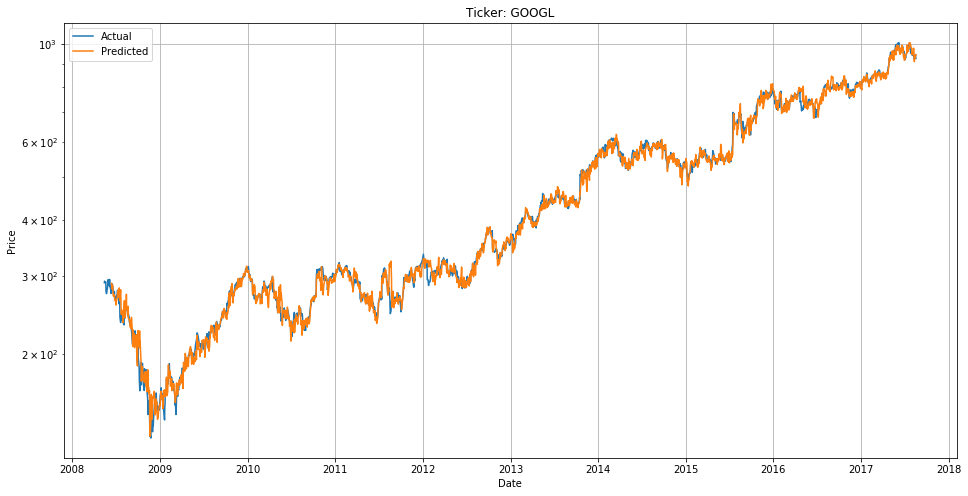

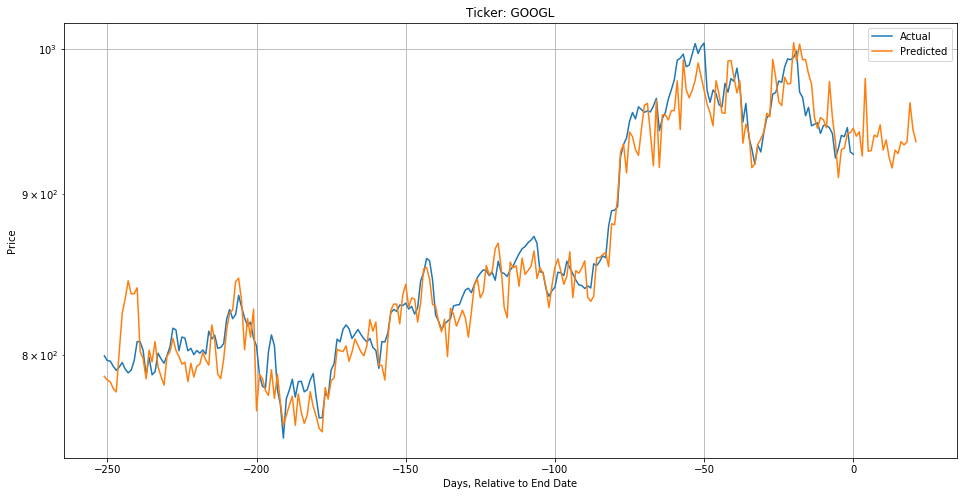

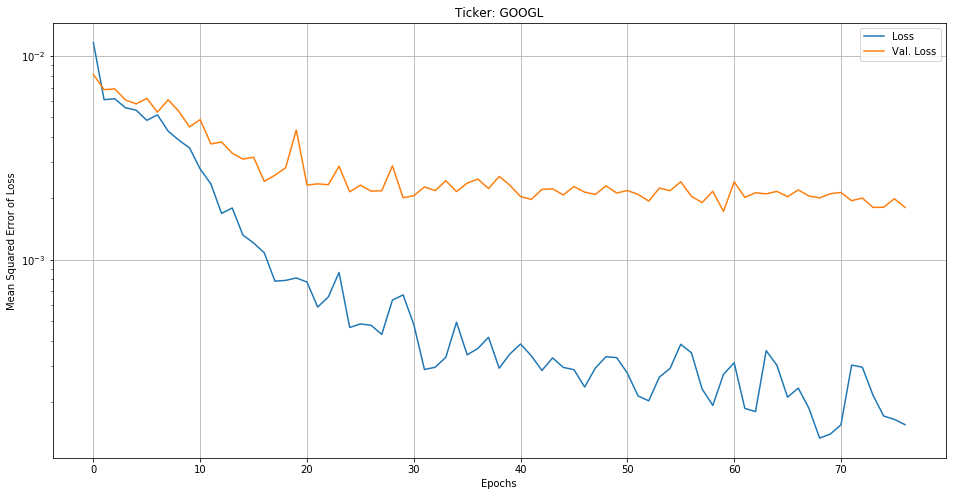

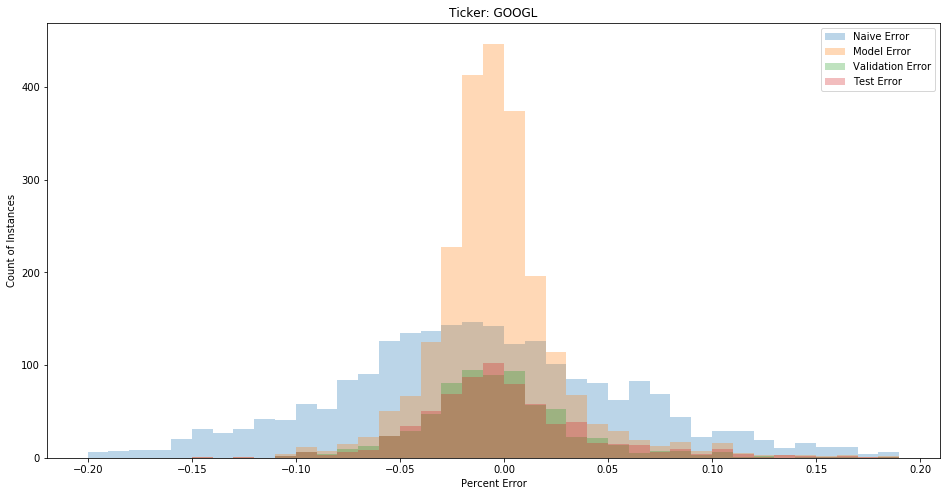

END GOOGL
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_121 (Conv1D)          (None, 21, 256)           17920     
_________________________________________________________________
max_pooling1d_121 (MaxPoolin (None, 11, 256)           0         
_________________________________________________________________
conv1d_122 (Conv1D)          (None, 11, 128)           98432     
_________________________________________________________________
max_pooling1d_122 (MaxPoolin (None, 6, 128)            0         
_________________________________________________________________
lstm_121 (LSTM)              (None, 6, 64)             49408     
_________________________________________________________________
lstm_122 (LSTM)              (None, 32)                12416     
_________________________________________________________________
dense_121 (Dense)            (None, 4)                 132       


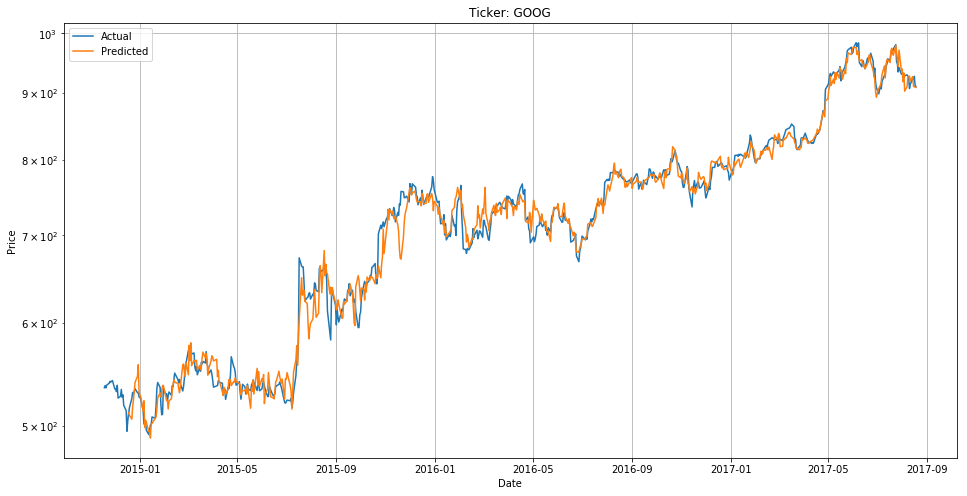

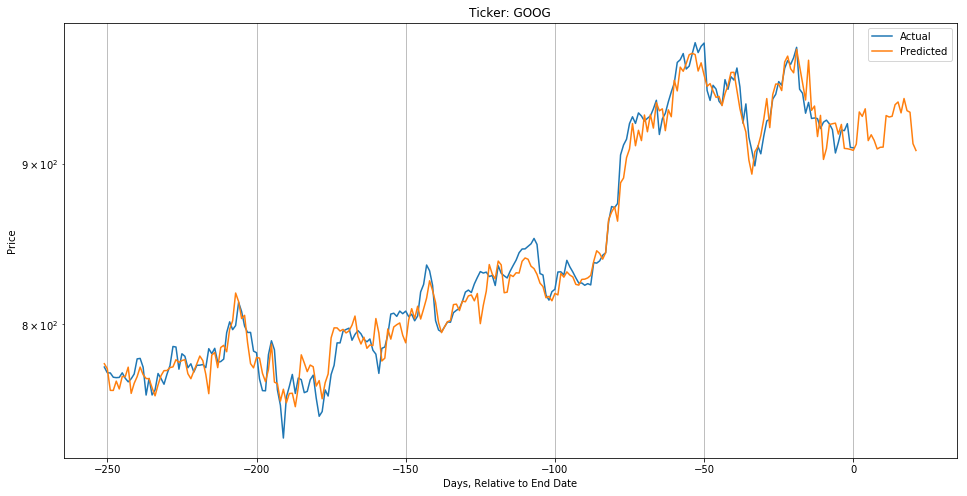

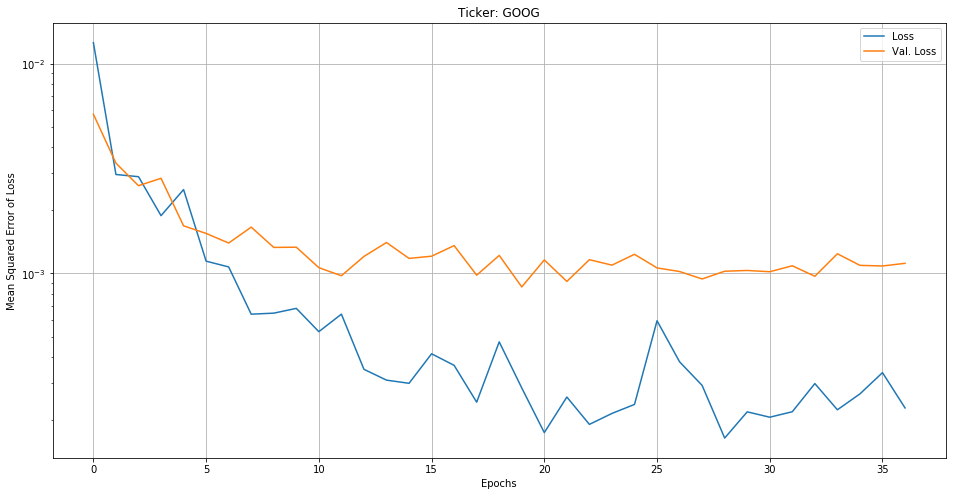

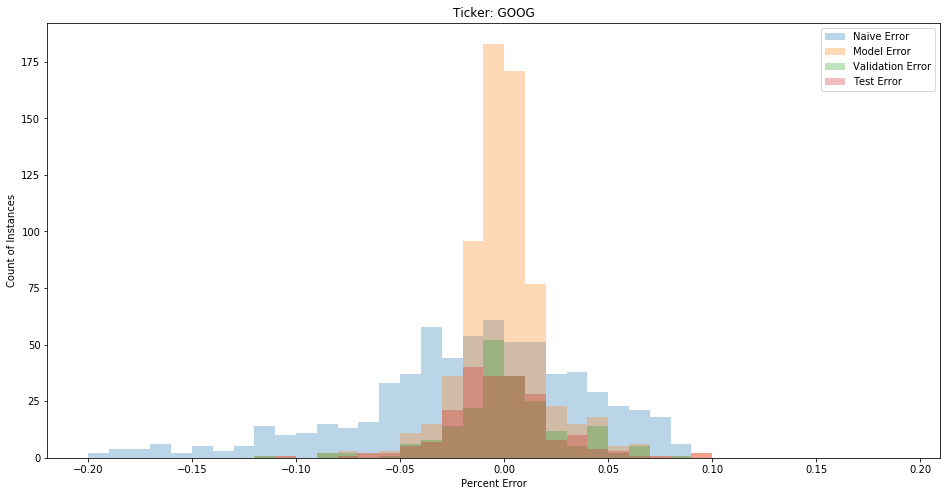

END GOOG


In [557]:
results = {}

for ticker in tickers:
    # get data back in frames
    x, y, dates = get_data(ticker, start_date, end_date, use_columns, predict_column, frame_length, advance)

    # split into training, validation, and testing
    x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.6)
    x_valid, x_test, y_valid, y_test = train_test_split(x_temp, y_temp, test_size=0.5)

    # fit model and return best
    model, history = fit_model(x_train, x_valid, y_train[:, 0], y_valid[:, 0])
    
    # make predictions
    y_hat = np.append(np.zeros(advance)*np.nan, model.predict(x).reshape(-1) * y[:, 1])
    y_valid_hat = model.predict(x_valid).reshape(-1) * y_valid[:, 1]
    y_test_hat = model.predict(x_test).reshape(-1) * y_test[:, 1]

    # naive prediction error
    naive_diff = y[:-advance, 1] / y[advance:, 1] - 1

    # model prediction errors
    y_diff = y_hat[advance:-advance] / y[advance:, 1] - 1
    y_valid_diff = (y_valid_hat / (y_valid[:, 0] * y_valid[:, 1])) - 1
    y_test_diff = (y_test_hat / (y_test[:, 0] * y_test[:, 1])) - 1

    # results dictionary for aggregates
    results[ticker] = {}
    results[ticker]['naive_diff'] = naive_diff
    results[ticker]['y_diff'] = y_diff
    results[ticker]['y_valid_diff'] = y_valid_diff
    results[ticker]['y_test_diff'] = y_test_diff

    # print results
    print()
    print_accuracy(naive_diff, name='Naive')
    print_accuracy(y_diff, name='Model')
    print_accuracy(y_valid_diff, name='Validation')
    print_accuracy(y_test_diff, name='Test')

    # make plots
    # actual versus predicted
    plt.figure(figsize=(16, 8))
    plt.title('Ticker: %s' % ticker.upper())
    plt.plot(dates, y[:, 1], label='Actual')
    plt.plot(dates, y_hat[:-advance], label='Predicted')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.gca().set_yscale('log')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # close up view of most recent year with future prediction
    plt.figure(figsize=(16, 8))
    plt.title('Ticker: %s' % ticker.upper())
    plt.plot(range(-251, 1), y[-252:, 1], label='Actual')
    plt.plot(range(-251, advance+1), y_hat[-252-advance:], label='Predicted')
    plt.xlabel('Days, Relative to End Date')
    plt.ylabel('Price')
    plt.gca().set_yscale('log')
    plt.grid(True)
    plt.legend()
    plt.show()

    # loss curves
    plt.figure(figsize=(16, 8))
    plt.title('Ticker: %s' % ticker.upper())
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Val. Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error of Loss')
    plt.gca().set_yscale('log')
    plt.grid(True)
    plt.legend()
    plt.show()

    # histograms of errors
    bins = np.arange(-0.2, 0.2, .01)
    plt.figure(figsize=(16, 8))
    plt.title('Ticker: %s' % ticker.upper())
    plt.hist(naive_diff, alpha=0.3, bins=bins, label='Naive Error')
    plt.hist(y_diff, alpha=0.3, bins=bins, label='Model Error')
    plt.hist(y_valid_diff, alpha=0.3, bins=bins, label='Validation Error')
    plt.hist(y_test_diff, alpha=0.3, bins=bins, label='Test Error')
    plt.xlabel('Percent Error')
    plt.ylabel('Count of Instances')
    plt.legend()
    plt.show()
    print('END %s' % ticker.upper())